In [1]:
#install.packages('reshape')

In [41]:
library(nlme)
library(multcomp)
options(jupyter.plot_mimetypes = "image/png")
library(ggplot2)
library(corrplot)
library(gridExtra)
library(grid)
library(data.table)
library(effects)
library(xtable)
library(reshape)
library(lsmeans)

# Load Data

In [42]:
stat_sum_single <- function(fun, geom="point", ...) {
  stat_summary(fun.y=fun, colour="red", geom=geom, size = 3, ...)
}

In [43]:
data = read.csv("../data_meta_analysis/Data_Classifications_v8b.csv")

In [44]:
data<-data[c('PID','Info.type','Accuracy.50','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing',
             'Coregistration','Pattern.normalization.type','Num_subs',
             'Voxel.numbers','Training.setsize')]

factors<-c('Info.type','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing',
           'Coregistration','Pattern.normalization.type','Num_subs',
          'Voxel.numbers','Training.setsize')

for (pid in unique(data$PID)){
    #print('--')
    #print(pid)
    #print(nrow(data1[data1$PID==pid,]))
    #print('--')
    data[data$PID==pid,'n_per_study']=nrow(data[data$PID==pid,])
}

In [45]:
R3 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_after_clustering_lr_v8b.csv"))
R3names = colnames(R3)

i=1
for (name in R3names){
    R3names[i]<-paste(sep='','R3',name)
    i=i+1
}
R3names
colnames(R3)<-R3names

[1] "R3Precentral"         "R3Frontal_Mid"        "R3Frontal_Mid_Orb"   
 [4] "R3Frontal_Inf_Orb"    "R3Frontal_Inf_Oper"   "R3Frontal_Inf_Tri"   
 [7] "R3Supp_Motor_Area"    "R3Cingulum_Mid"       "R3Cingulum_Ant"      
[10] "R3Frontal_Sup"        "R3Frontal_Sup_Medial" "R3Insula"

In [46]:
data = cbind(data,R3) # will bind with other region names too 


# mscl fixed 
data<-data[!data$Classifier.type=='neural-net',] # no observations but still has a level
data[data$Scanner=='4T','Scanner']='3T' # only one observatoin with 3T

data$PID<-as.factor(data$PID)
data$Info.type<-as.factor(data$Info.type)
data$Smoothing<-as.factor(data$Smoothing)
data$Roi.Search<-as.factor(data$Roi.Search)
data$Classifier.type<-as.factor(data$Classifier.type)
data$Coregistration<-as.factor(data$Coregistration)
data$Pattern.type<-as.factor(data$Pattern.type)

#data[data$Pattern.normalization.type=='Normalized Spatially']

data$Pattern.normalization.type<-as.factor(data$Pattern.normalization.type)

data<-droplevels(data)

data_50<-subset(data,!is.na(Accuracy.50))
data_50_non<-subset(data,!is.na(Accuracy.50)& Significance==0)
data_50_sig<-subset(data,!is.na(Accuracy.50) & Significance==1)
#head(data_50_sig)
nrow(data_50_sig)




[1] 512

In [47]:
d<-data_50_sig[c('Accuracy.50','PID',R3names)]
head(d)
nrow(d)

,Accuracy.50,PID,R3Precentral,R3Frontal_Mid,R3Frontal_Mid_Orb,R3Frontal_Inf_Orb,R3Frontal_Inf_Oper,R3Frontal_Inf_Tri,R3Supp_Motor_Area,R3Cingulum_Mid,R3Cingulum_Ant,R3Frontal_Sup,R3Frontal_Sup_Medial,R3Insula
4,0.528,1,0,0,0,0,0,0,0,0,0,0,0,1
9,0.535,1,0,0,0,0,0,0,0,0,0,0,0,1
10,0.541,1,0,0,0,0,0,1,0,0,0,0,0,0
11,0.543,1,0,0,0,0,0,0,0,0,0,0,0,1
12,0.593,1,0,0,0,0,0,1,0,0,0,0,0,0
16,0.640,2,1,0,0,0,0,0,0,0,0,0,0,0


[1] 512

# Mixed Effects 

In [48]:
R1names_string<-c()
for (R in R3names){
    R1names_string<-paste(R1names_string,R,sep='+')
    
}
R1names_string<-substring(R1names_string, 2)
R1names_string

[1] "R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula"

In [49]:
d<-data_50_sig[c('Accuracy.50','PID',R3names)]
gmean<-mean(d$Accuracy.50)
d$Accuracy.50_wo_gmean<-d$Accuracy.50-gmean
region_model<-lme(as.formula(paste('Accuracy.50_wo_gmean~-1+',R1names_string,sep='')),random=~1|PID,data=d,method='REML')
summary(region_model)

Linear mixed-effects model fit by REML
 Data: d 
        AIC       BIC   logLik
  -1320.823 -1261.818 674.4114

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:   0.0652236 0.05174028

Fixed effects: as.formula(paste("Accuracy.50_wo_gmean~-1+", R1names_string,      sep = "")) 
                            Value   Std.Error  DF    t-value p-value
R3Precentral          0.008969800 0.008373269 426  1.0712423  0.2847
R3Frontal_Mid        -0.018071556 0.007595325 426 -2.3793000  0.0178
R3Frontal_Mid_Orb    -0.026304279 0.013114997 426 -2.0056642  0.0455
R3Frontal_Inf_Orb     0.007207193 0.012921403 426  0.5577718  0.5773
R3Frontal_Inf_Oper   -0.011792987 0.011959218 426 -0.9861002  0.3246
R3Frontal_Inf_Tri    -0.004023176 0.010246785 426 -0.3926281  0.6948
R3Supp_Motor_Area     0.011930891 0.010173731 426  1.1727154  0.2416
R3Cingulum_Mid        0.001961158 0.015612840 426  0.1256119  0.9001
R3Cingulum_Ant        0.013319866 0.012716928 426  1.0474123  0.2955
R3Front

In [50]:
# d<-data_50_sig[c('Accuracy.50','PID',R3names)]
# gmean<-mean(d$Accuracy.50)
# d$Accuracy.50_wo_gmean<-d$Accuracy.50-gmean
# region_model<-lme(as.formula(paste('Accuracy.50_wo_gmean~-1+',R1names_string,sep='')),random=~1|PID,data=d,method='ML')
# summary(region_model)

In [51]:
summary(region_model)

Linear mixed-effects model fit by REML
 Data: d 
        AIC       BIC   logLik
  -1320.823 -1261.818 674.4114

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:   0.0652236 0.05174028

Fixed effects: as.formula(paste("Accuracy.50_wo_gmean~-1+", R1names_string,      sep = "")) 
                            Value   Std.Error  DF    t-value p-value
R3Precentral          0.008969800 0.008373269 426  1.0712423  0.2847
R3Frontal_Mid        -0.018071556 0.007595325 426 -2.3793000  0.0178
R3Frontal_Mid_Orb    -0.026304279 0.013114997 426 -2.0056642  0.0455
R3Frontal_Inf_Orb     0.007207193 0.012921403 426  0.5577718  0.5773
R3Frontal_Inf_Oper   -0.011792987 0.011959218 426 -0.9861002  0.3246
R3Frontal_Inf_Tri    -0.004023176 0.010246785 426 -0.3926281  0.6948
R3Supp_Motor_Area     0.011930891 0.010173731 426  1.1727154  0.2416
R3Cingulum_Mid        0.001961158 0.015612840 426  0.1256119  0.9001
R3Cingulum_Ant        0.013319866 0.012716928 426  1.0474123  0.2955
R3Front

In [52]:
#region_model$fixDF


In [53]:
R3namesnew<-c()
for (R in R3names){
    R3namesnew<-c(R3namesnew,gsub("R3", "",R))
    
}
R3namesnew

[1] "Precentral"         "Frontal_Mid"        "Frontal_Mid_Orb"   
 [4] "Frontal_Inf_Orb"    "Frontal_Inf_Oper"   "Frontal_Inf_Tri"   
 [7] "Supp_Motor_Area"    "Cingulum_Mid"       "Cingulum_Ant"      
[10] "Frontal_Sup"        "Frontal_Sup_Medial" "Insula"

In [54]:
# get data for plot 
fits<-c()
se<-c()
i=1
for (name in R3names){
    ef<-effect(name,region_model)
    fits[i]<-tail(ef$fit, n=1)
    se[i]<-tail(ef$se, n=1)
    i=i+1 
}
dd = data.table(name=R3namesnew,se=se,Accuracy=fits)



In [55]:
#dd$Accuracy_Gmean=dd$Accuracy+gmean

In [56]:
dd

name,se,Accuracy
Precentral,0.01132234,0.002590143
Frontal_Mid,0.01053940,-0.017885388
Frontal_Mid_Orb,0.01537222,-0.029104540
Frontal_Inf_Orb,0.01435865,0.002756554
Frontal_Inf_Oper,0.01356611,-0.014587778
Frontal_Inf_Tri,0.01225072,-0.007573497
Supp_Motor_Area,0.01312608,0.006704418
Cingulum_Mid,0.01787844,-0.002184777
Cingulum_Ant,0.01467010,0.008558817
Frontal_Sup,0.01242779,-0.000155412


In [57]:
gmean

[1] 0.6100623

In [58]:
dd$Accuracy_gmean = dd$Accuracy+gmean
dd

name,se,Accuracy,Accuracy_gmean
Precentral,0.01132234,0.002590143,0.6126524
Frontal_Mid,0.01053940,-0.017885388,0.5921769
Frontal_Mid_Orb,0.01537222,-0.029104540,0.5809578
Frontal_Inf_Orb,0.01435865,0.002756554,0.6128189
Frontal_Inf_Oper,0.01356611,-0.014587778,0.5954745
Frontal_Inf_Tri,0.01225072,-0.007573497,0.6024888
Supp_Motor_Area,0.01312608,0.006704418,0.6167667
Cingulum_Mid,0.01787844,-0.002184777,0.6078775
Cingulum_Ant,0.01467010,0.008558817,0.6186211
Frontal_Sup,0.01242779,-0.000155412,0.6099069


pdf 
  2

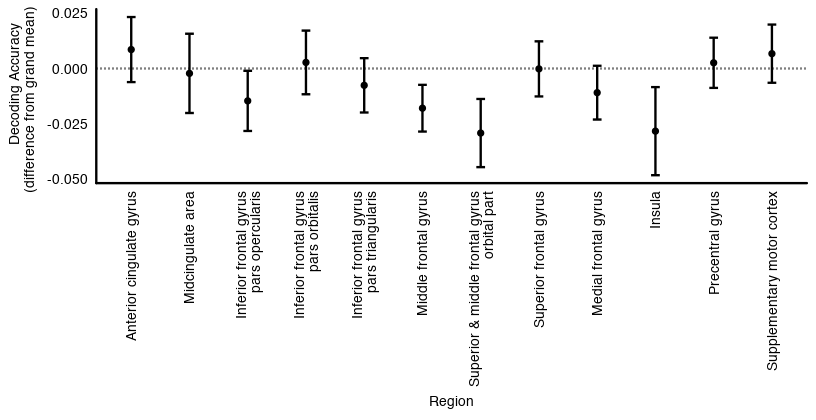

In [69]:


p<-ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), 
          data = dd) +
geom_point(size=1)+geom_errorbar(width=0.15)

mainlinewidth=.5
textsize = 8
labelsize = 8

p<-p+geom_hline(yintercept=0,linetype='dotted')
p<-p+theme(axis.line.x = element_line(color="black", size = mainlinewidth),
        axis.line.y = element_line(color="black", size = mainlinewidth))

p<-p+xlab('Region')
p<-p+ylab('Decoding Accuracy \n (difference from grand mean)')
p<-p+theme(panel.background=element_blank())
p<-p+theme(axis.text.y = element_text(family="Helvetica",size=textsize,colour='black'))
p<-p+theme(axis.text.x = element_text(family="Helvetica",angle = 90, vjust=0.5,
                                      hjust = 1,size=textsize,colour='black'))
p<-p+theme(plot.title = element_text(family="Helvetica",size=labelsize,colour='black'))
p<-p+theme(axis.title.x = element_text(family="Helvetica",size=labelsize,,colour='black'))
p<-p+theme(axis.title.y = element_text(family="Helvetica",size=labelsize,hjust=.8,colour='black'))

rlabels = c('Anterior cingulate gyrus','Midcingulate area',
            'Inferior frontal gyrus\npars opercularis',
           'Inferior frontal gyrus\npars orbitalis',
            "Inferior frontal gyrus\npars triangularis",
           'Middle frontal gyrus',
            'Superior & middle frontal gyrus\norbital part',
           'Superior frontal gyrus',
            'Medial frontal gyrus',
            'Insula',
            'Precentral gyrus',
           'Supplementary motor cortex')
p<-p+scale_x_discrete(labels=rlabels)

p<-p+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())

# setEPS()
# postscript('../Figures/Supp_accuracy_by_region_medium_mixed_effects_v8b.eps',width=6,height=4)
# p
# dev.off()


# png('../Figures/Supp_accuracy_by_region_medium_mixed_effects_v8b.png',width=6,height=4,
#      units="in",res=400)
# p
# dev.off()

tiff(filename = "../Figures_JOCN_Final/Figure6.tiff",
     width=6.8,height=3.5, units = "in", res=1000,
     compression = 'none')
p
dev.off()

options(repr.plot.width=6.8, repr.plot.height=3.5)
p

In [21]:
region_model_ml<-lme(as.formula(paste('Accuracy.50_wo_gmean~-1+',R1names_string,sep='')),random=~1|PID,data=d,method='ML')
region_model_baseline<-lme(Accuracy.50_wo_gmean~1,random=~1|PID,data=d,method='ML')
anova(region_model_ml,region_model_baseline)


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
region_model_ml,"lme.formula(fixed = as.formula(paste(""Accuracy.50_wo_gmean~-1+"", R1names_string, sep = """")), data = d, random = ~1 | PID, method = ""ML"")",1,14,-1407.535,-1348.199,717.7676,,NA,NA
region_model_baseline,"lme.formula(fixed = Accuracy.50_wo_gmean ~ 1, data = d, random = ~1 | PID, method = ""ML"")",2,3,-1411.941,-1399.226,708.9704,1 vs 2,17.59439,0.09148201
